## Time Series Model for Cow Milk Production Using N-Beats Lightning

The Cow Milk Production dataset is a time series toy dataset that can be used to evaluate a time series model against a known and well established problem. We will use the N-Beats Lightning algorithm in this repository to forecast future outcomes based on past data points.

### INTRODUCTION

The problem is to forecast the monthly milk production per cow in an agriculture environment. The milk production dataset describes a time-series of milk production (in pounds per cow) over 13 years (1962-1974), and there are 156 observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model.


### Summary Statistics and Visualizations 

We begin by reading the data and summarizing the variables.

In [1]:
#%% Import necessary libraries
from nbeats_lightning.nbeats import *
from nbeats_lightning.loaders import *
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm
tqdm.pandas()
%matplotlib inline


# Load the milk.csv dataset
milk = pd.read_csv('data/milk.csv', index_col=0)
milk.head()

,milk_production_pounds
month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


The dataset consists of two columns:

- *month:*  The month during which the data was collected, starting from January 1962.
- *milk_production_pounds:*   The amount of milk produced in pounds.


In [2]:
milk.describe()

,milk_production_pounds
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


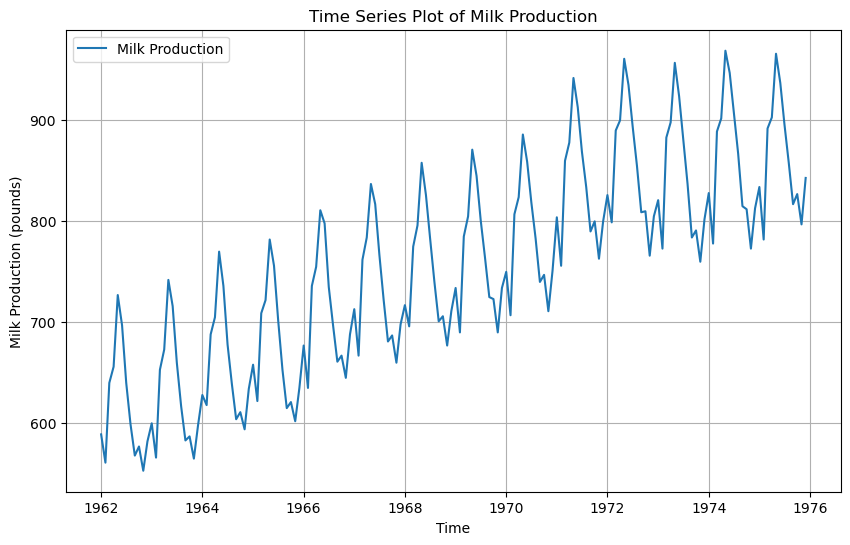

In [3]:
# Convert the 'month' column to datetime format
milk['month'] = pd.to_datetime(milk.index)

# Create Time Series Plot
plt.figure(figsize=(10, 6))
plt.plot(milk['month'], milk['milk_production_pounds'], label='Milk Production')
plt.title('Time Series Plot of Milk Production')
plt.xlabel('Time')
plt.ylabel('Milk Production (pounds)')
plt.legend()
plt.grid(True)
plt.show()


The Time Series Plot above illustrates the trend and seasonality in milk production over time.
It's apparent that there's a recurring pattern every year, which suggests a strong seasonal
component. Additionally, there seems to be a general upward trend in milk production over the years.
Next, let's move on to the Seasonal Decomposition to decompose the time series into its trend,
seasonal, and residual components. This will provide a clearer picture of the underlying patterns
in the data.

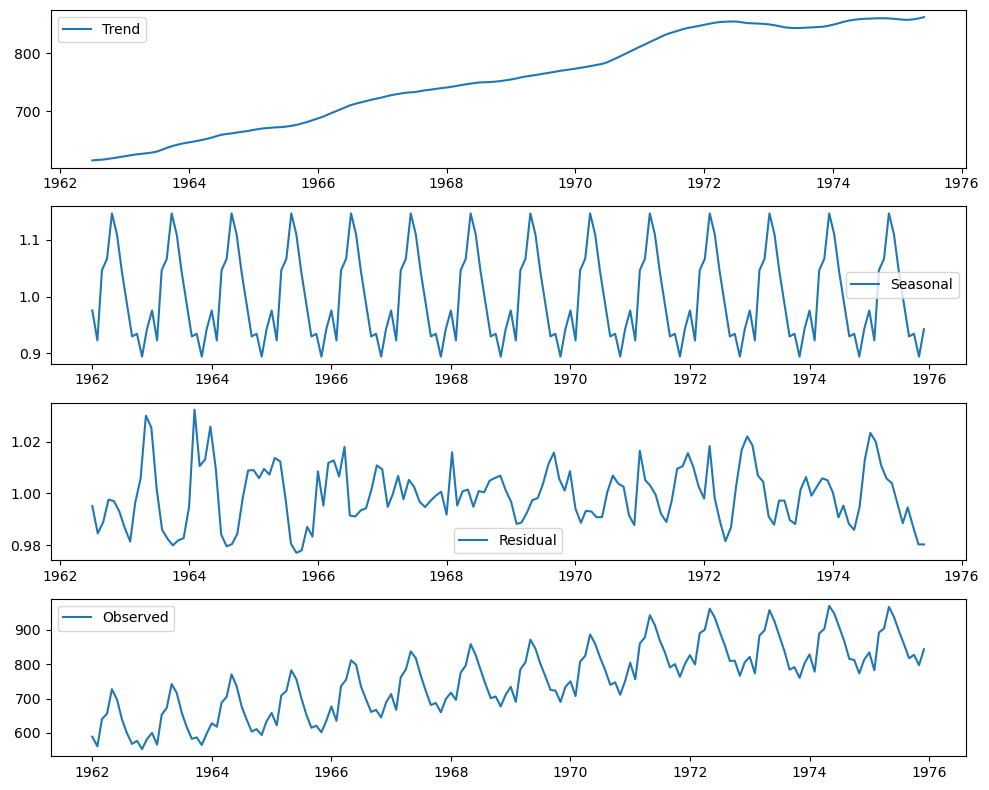

In [4]:
milk.set_index('month', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(milk['milk_production_pounds'], model='multiplicative')

# Plot the seasonal decomposition again with the corrected attribute name
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(milk['milk_production_pounds'], label='Observed')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The Seasonal Decomposition plot breaks down the time series into three components:

* Trend: Shows a general upward trend in milk production over the years.
* Seasonal: Illustrates a clear seasonal pattern that repeats every year.
* Residual: Contains the residual values after the trend and seasonal components have
been removed.

### Model Specification

Next we will create a PyTorch Lightning DataModule to load the data, and 3 nbeats_lightning models, 2 generic, and 1 interpretable, with which to train the data and then predict.  We will then compare the predictions of the two models
against the actual data and to each other.

In [7]:
#%%
# Define hyperparameters
forecast_length = 6
backcast_length = 3 * forecast_length
batch_size = 64
milkval = milk.values.flatten() # flat numpy array

# Create a simple pytorch dataloader
dm = TimeSeriesDataModule(
  data=milkval,
  batch_size=batch_size,
  backcast=backcast_length,
  forecast=forecast_length)

# A Generic N-Beats Model.  
# - 5 stacks
#   - 1 generic(128) block per stack 
#     - 4 waveform theta parameters per block

generic_milkmodel_5_1_256 = NBeatsNet (
  backcast = backcast_length,
  forecast = forecast_length, 
  generic_architecture = True,
  n_blocks_per_stack = 1,
  n_stacks = 5,
  thetas_dim = 4,
  share_weights = False,
  g_width = 256,
  active_g = False,
  sum_losses = False)

# Same model as above, but with g-activation
# g-activation applies an activation funtion to the linear funtions (gb and gf)
# which are found by the network in the last layer of each block using the 
# theta parameters found in the preceding layer. Applications of this activation
# function seems to help the generic model converge faster.
# g_activation is not a feature found in the original N-Beats paper.

generic_milkmodel_actg_5_1_256 = NBeatsNet(
  backcast = backcast_length,
  forecast = forecast_length, 
  generic_architecture = True,
  n_blocks_per_stack = 1,
  n_stacks = 5,
  thetas_dim = 4,
  g_width = 256,
  share_weights = False,
  active_g = True,
  sum_losses = False)

# An Interpretable N-Beats Model, 
#   - 2 stacks
#     - 3 trend(256) blocks in first stack
#     - 3 seasonality(2048) in second stack
interpretable_milkmodel = NBeatsNet(
  backcast = backcast_length,
  forecast = forecast_length, 
  generic_architecture = False,
  n_blocks_per_stack = 3,
  share_weights = True,  
  sum_losses=False
  )


You will notice that the model `generic_milkmodel_actg_5_1_512` is identical to generic_milkmodel_5_1_512 save for the
acttivate_g parameter. g-activation applies an activation funtion to the linear funtions (gb and gf) which are found by the network in the last layer of each block using the theta parameters found in the preceding layer. 

You can enable this feature by setting activate_g to True.  Enabling this activation function seems to help the Generic model. g_activation is not a feature found in the original N-Beats paper.

In [8]:
#%%
# Train the generic model
generic_trainer =  pl.Trainer(
  accelerator='auto'
  ,max_epochs=1000,
)

generic_trainer.fit(generic_milkmodel_5_1_256, datamodule=dm)
generic_trainer.save_checkpoint('generic_milkmodel_5_1_256.ckpt')
generic_trainer.validate(generic_milkmodel_5_1_256, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | SMAPELoss  | 0     
1 | stacks  | ModuleList | 1.0 M 
---------------------------------------
1.0 M     Trainable params
1.1 K     Non-trainable params
1.0 M     Total params
4.088     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\DanielByrne\AppData\Local\miniconda3\envs\nbeats\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\DanielByrne\AppData\Local\miniconda3\envs\nbeats\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\DanielByrne\AppData\Local\miniconda3\envs\nbeats\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s, v_num=122, train_loss=68.50, val_loss=68.60]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 28.15it/s, v_num=122, train_loss=68.50, val_loss=68.60]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     68.62914276123047     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 68.62914276123047}]

In [10]:
#%%
# Train the generic model with g_activation
generic_act_trainer =  pl.Trainer(
  accelerator='auto'
  ,max_epochs=500
)

generic_act_trainer.fit(generic_milkmodel_actg_5_1_256, datamodule=dm)
generic_act_trainer.validate(generic_milkmodel_actg_5_1_256, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | SMAPELoss  | 0     
1 | stacks  | ModuleList | 4.0 M 
---------------------------------------
4.0 M     Trainable params
2.1 K     Non-trainable params
4.0 M     Total params
16.038    Total estimated model params size (MB)


Epoch 499: 100%|██████████| 2/2 [00:00<00:00, 49.76it/s, v_num=120, train_loss=3.900, val_loss=3.670]  

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 2/2 [00:00<00:00, 10.87it/s, v_num=120, train_loss=3.900, val_loss=3.670]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    3.6664438247680664     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 3.6664438247680664}]